In [31]:
#Input
clustered_data = '../nf_output/data/Visium_FFPE_V43T08-041_D_ref_clustered.h5ad'
path_to_project = '~/Project'

In [32]:
import anndata
import sys
import re
import os
sys.path.append(os.path.join(path_to_project, 'Spatial-Transcriptomics/PDAC/clustering/clustering_assessment'))
from metrics_and_visualization_functions import *

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_samples, adjusted_rand_score, rand_score
from matplotlib.backends.backend_pdf import PdfPages
import scanpy as sc
import seaborn as sns
import harmonypy as hm

def clustering_plot(ax, adata, colname):
    sp_size = 10000/len(adata.obs)
    sc.pl.spatial(adata, img_key="hires", color=colname, show=False, ax=ax,  spot_size=1, size = sp_size, scale_factor = 1, title=None)

def umap(ax, adata, colname):
    '''plotting predicted labels by UMAP'''
    sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=colname, title=['Predicted labels'], show=False, ax=ax)

def silhouette_metrics(adata, cluster_labels):
    X = adata.obsm['emb_pca']
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    return sample_silhouette_values

def lisi_metrics(data, colname):
    #X = data.obs.loc[:,['x','y']]
    X = data.obsm['emb_pca']
    metadata = data.obs.iloc[:,2:]
    lisi_df = hm.compute_lisi(X, metadata, [colname])
    lisi_values = lisi_df.flatten()
    return lisi_values

def clustered_distribution_plot(ax, values, cluster_labels, metric):
    '''
    metric to evaluate the clustering 
    '''
    avg_value = np.mean(values)
    y_lower = 10
    cluster_number = len(np.unique(cluster_labels))
    for i in range(cluster_number):
        # Aggregate the values for samples belonging to the same cluster
        ith_cluster_values = values[cluster_labels == i]
        ith_cluster_values.sort()

        size_cluster_i = ith_cluster_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.tab20(2 * i) # to select the color of the different clusters

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_values,
            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(np.mean([values.min(), avg_value]), y_lower + 0.5 * size_cluster_i, str(i + 1),
            va='center', ha='right', fontsize=9)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=avg_value, color="red", linestyle="--")

    ax.set_title(f"{metric} for the various clusters.")
    ax.set_xlabel(f"{metric}")
    ax.set_ylabel("Cluster label")

    ax.set_xlim(values.min() - 0.05, values.max() + 0.05)
    ax.set_yticks([])  # Clear the yaxis labels / ticks

    return avg_value
    
def rand_index(adata, col_label_true, col_label_pred):
    labels_true = adata.obs[col_label_true]
    labels_pred = adata.obs[col_label_pred]
    ri = rand_score(labels_true, labels_pred)
    return ri

def adjusted_rand_index(adata, col_label_true, col_label_pred):
    labels_true = adata.obs[col_label_true]
    labels_pred = adata.obs[col_label_pred]
    ari = adjusted_rand_score(labels_true, labels_pred)
    return ari

def metrics_and_visualizations(adata, clustering_colname, col_label_true=None, show=False):
    '''
    Calculates different metrics and generates figures to compare clustering
    show ('True/False') print directly the figures
    col_label_true : columns name that corresponds to the ground truth (list or str)
    '''

    #identify the method, the number of cluster and the refinement condition (GraphST)
    p = clustering_colname.split('_')
    method = p[0]
    n_clusters_list = np.unique(adata.obs.loc[:,clustering_colname])
    n_clusters = len(n_clusters_list)

    if len(p) == 2: # condition without refinement
        refinement = False
    elif len(p) == 3:
        refinement = True

    figures = []
    all_metrics = []
    
    # figure 
    fig = plt.figure(figsize=(14, 14))
    gs = gridspec.GridSpec(3, 2, # 3 lines, # 3 columns
        height_ratios=[4, 4, 1.8]) # ratio of 3 for the two first lines and one for the last one

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax_table = fig.add_subplot(gs[2, :])
    ax_table.axis('off') #remove axis for the table
    plt.subplots_adjust(hspace=0.25)

    # graphics
    clustering_plot(ax1, adata, clustering_colname)
    umap(ax2, adata, clustering_colname)

    cluster_labels = adata.obs[clustering_colname].cat.codes.to_numpy()
    silhouette_values = silhouette_metrics(adata, cluster_labels)
    silhouette_avg = clustered_distribution_plot(ax3, silhouette_values, cluster_labels, 'Silhouette values')

    lisi_values = lisi_metrics(adata, clustering_colname)
    lisi_avg = clustered_distribution_plot(ax4, lisi_values, cluster_labels, 'LISI scores')

    # table
    metrics = {'method': method, 'refinement': refinement, 'number of clusters': n_clusters, 'silhouette average': round(silhouette_avg,3), 'lisi average': round(lisi_avg,3)}
    if col_label_true: 
        if isinstance(col_label_true, str):
            col_label_true = [col_label_true]
        for label in col_label_true:
            #ri = rand_index(adata, label, clustering_colname)
            #metrics[f'rand index ({label})'] = ri
            ari = adjusted_rand_index(adata, label, clustering_colname)
            metrics[f'adjusted rand index ({label})'] = round(ari, 3)
            
    metric_table = pd.DataFrame([metrics])
    table = ax_table.table(cellText=metric_table.values, colLabels=metric_table.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 3) #width, height

    plt.suptitle(clustering_colname, fontsize=14, fontweight="bold")
            
    if show == True:
        plt.show()
    plt.close(fig)
            
    figures.append(fig)
    all_metrics.append(metrics) 

    return figures, all_metrics

def final_table(df, show):
    '''
    Create the final metric table
    '''
    final_fig, ax_table = plt.subplots(figsize=(10,len(df)*0.5))
    ax_table.axis('off')
    table = ax_table.table(cellText=df.values, colLabels=df.columns, loc='center')
    #table.scale(1, 2) #width, height
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    if show == True:
        plt.show()
        plt.tight_layout()
    plt.close(final_fig)
    return final_fig

def line_plot(df, x, y, color, style, show):
    fig, ax = plt.subplots()
    sns.lineplot(data=df, x=x, y=y, hue=color, style=style, ax=ax)
    if y == 'silhouette average':
        plt.ylim(-0.3, 0.7)
    if y == 'lisi average':
        plt.ylim(1, 4)
    if 'adjusted rand index' in  y:
        plt.ylim(-0.2, 1)
    if show == True:
        plt.show()
    plt.close(fig)
    return fig

def loop_to_show_and_save(adata, col_label_true, show, filename=None):
    '''
    Parameters:
        - methods can be a string or a list of string
        - filename = name of the file where the figure will be saved
    '''
    graphST_columns = []
    for col in adata.obs.columns:
        if '_' in col: #GraphST create columns like {method}_{n_cluster}_refined
            graphST_columns.append(col)
    graphST_columns.sort()

    final_metric_table = []

    if filename:
        with PdfPages(filename) as pdf:
            for col in graphST_columns: 
                figures, all_metrics = metrics_and_visualizations(adata, col, col_label_true, show)
                final_metric_table.extend(all_metrics)
                for fig in figures:
                    pdf.savefig(fig)

            final_table_df = pd.DataFrame(final_metric_table)
            final_fig_table = final_table(final_table_df, show)
            pdf.savefig(final_fig_table)

            line_fig1 = line_plot(final_table_df, 'number of clusters', 'silhouette average', 'method', 'refinement', show)
            pdf.savefig(line_fig1)
            line_fig3 = line_plot(final_table_df, 'number of clusters', 'lisi average', 'method', 'refinement', show)
            pdf.savefig(line_fig3)
            if col_label_true:
                if isinstance(col_label_true, str):
                    col_label_true = [col_label_true]
                for label in col_label_true:
                    #line_fig4 = line_plot(final_table_df, 'number of clusters', f'rand index ({label})', 'method', 'refinement', show)
                    #pdf.savefig(line_fig4)
                    line_fig2 = line_plot(final_table_df, 'number of clusters', f'adjusted rand index ({label})', 'method', 'refinement', show)
                    pdf.savefig(line_fig2)        
        
    else:
        for col in graphST_columns:
            figures, all_metrics = metrics_and_visualizations(adata, col, col_label_true, show)
            final_metric_table.extend(all_metrics)

        final_table_df = pd.DataFrame(final_metric_table, show)
        final_fig_table = final_table(final_table_df)
        if show == True:
            line_plot(final_table_df, 'number of clusters', 'silhouette average', 'method', 'refinement', show)
            line_plot(final_table_df, 'number of clusters', 'lisi average', 'method', 'refinement', show)
            if col_label_true:
                if isinstance(col_label_true, str):
                    col_label_true = [col_label_true]
                for label in col_label_true:
                    #line_plot(final_table_df, 'number of clusters', f'rand index ({label})', 'method', 'refinement', show)
                    line_plot(final_table_df, 'number of clusters', f'adjusted rand index ({label})', 'method', 'refinement', show)

    return final_table_df

In [34]:
#col_label_true = ['uscore label', 'sctype + uscore label'] #columns used to calculate metrics that require ground true
col_label_true = ['sctype + uscore label'] #columns used to calculate metrics that require ground true



sample = os.path.basename(clustered_data)
sample_name = sample.replace("_clustered.h5ad", "")

pdf_output = f"{sample_name}.pdf"
table_output = f"{sample_name}_final_table.csv"

In [35]:
adata = anndata.read_h5ad(clustered_data)

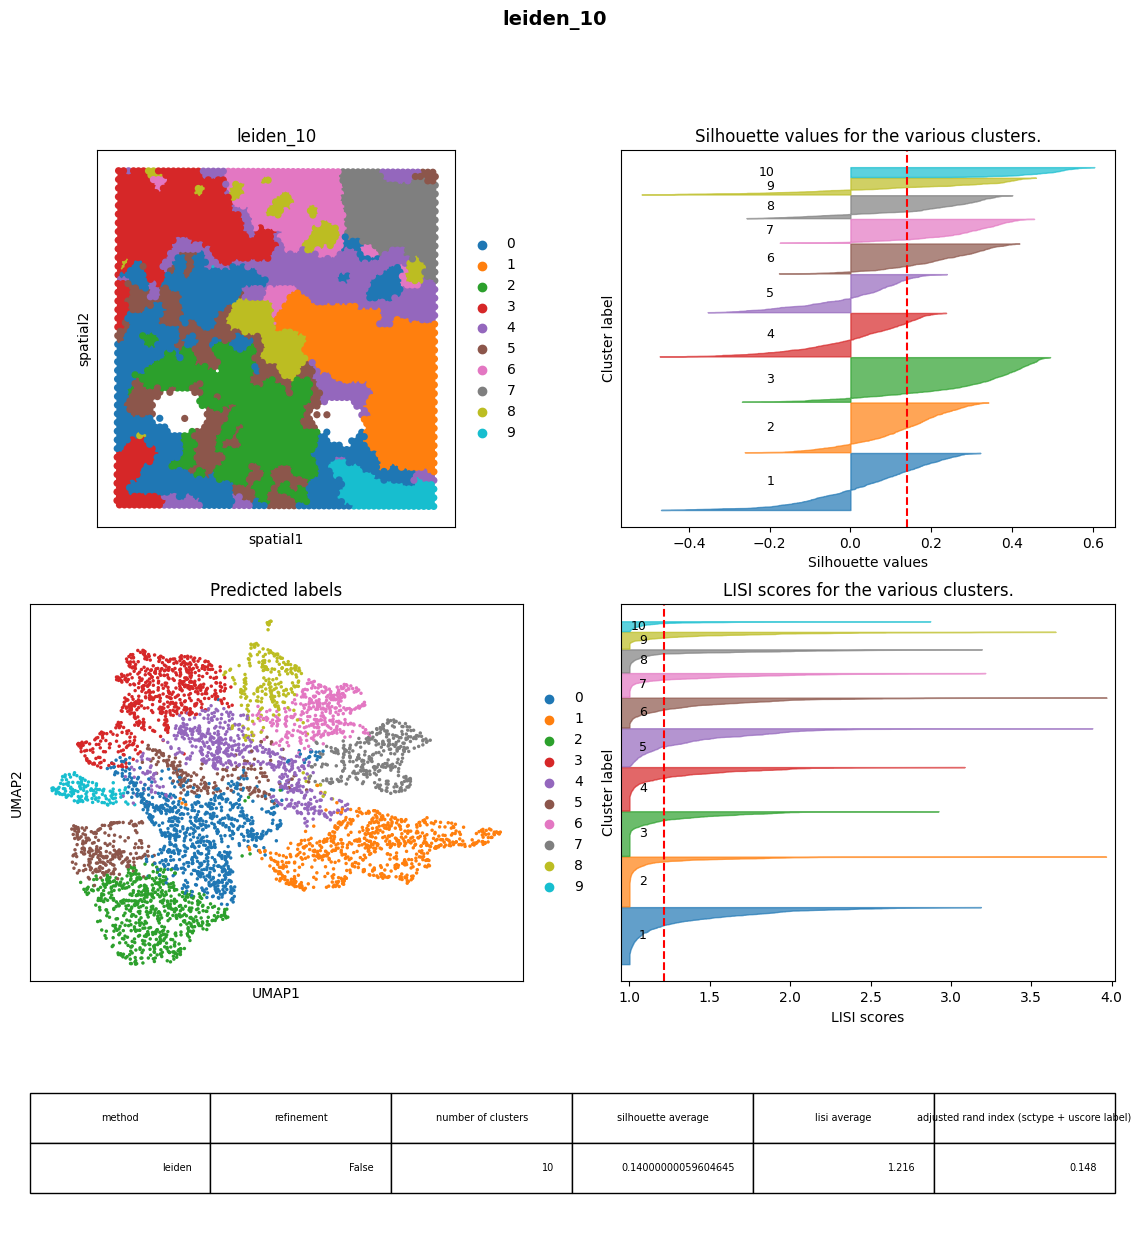

In [ ]:
table = loop_to_show_and_save(adata, col_label_true, show=True, filename=pdf_output)

In [ ]:
table.to_csv(table_output, index=False)